38.699997
Original tiff:


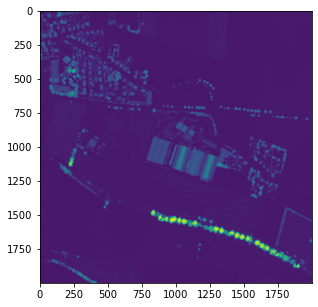

Theshold= 5
Geglättet:


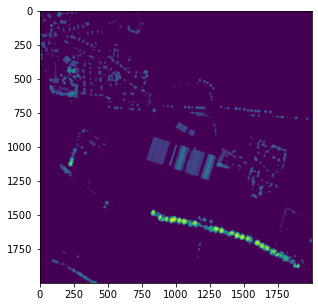

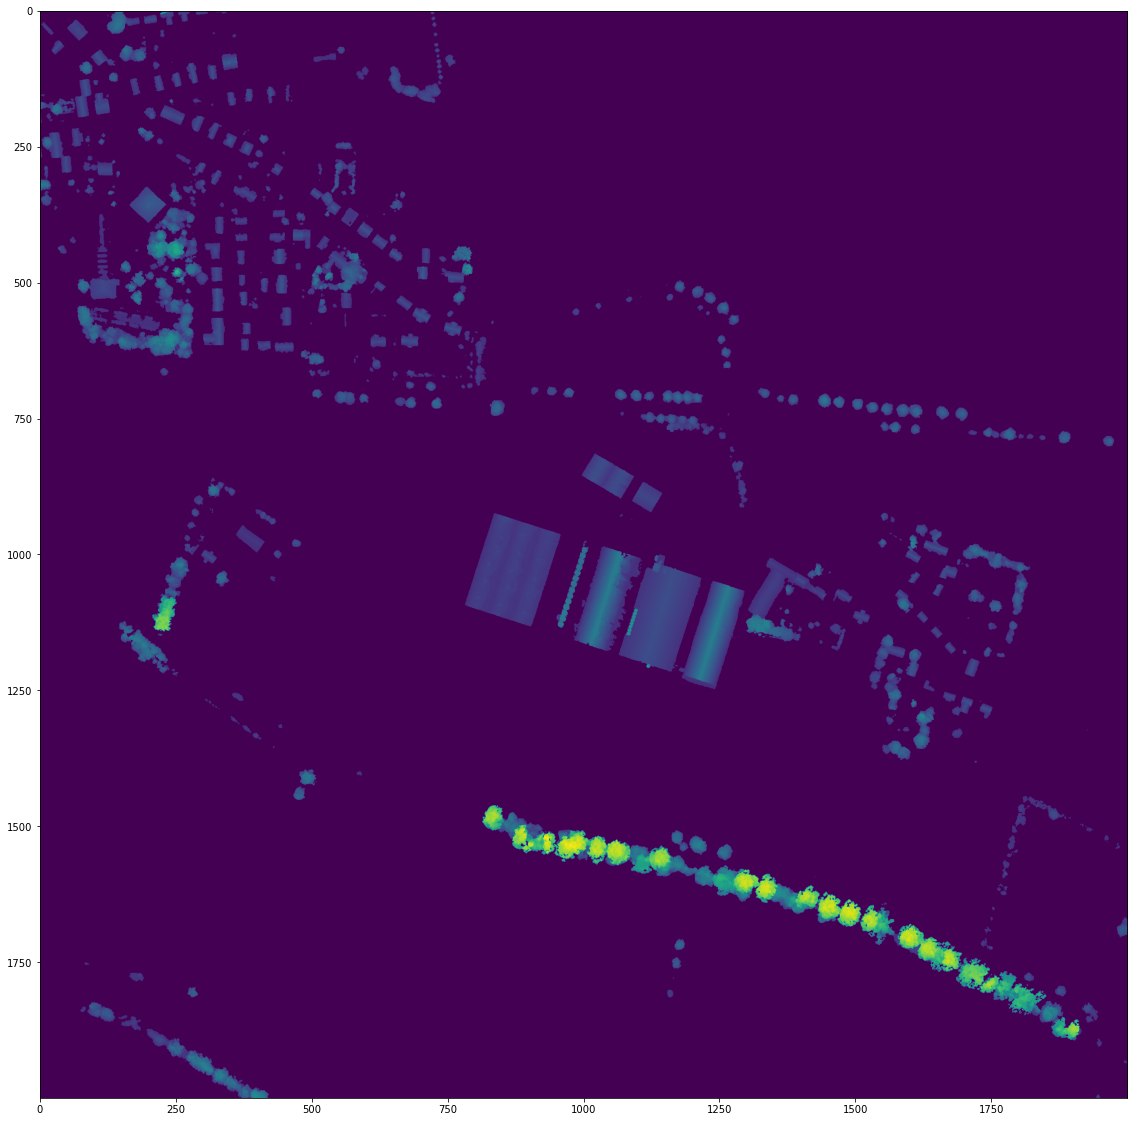

In [1]:
from scipy import ndimage as ndi
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage import median_filter
import matplotlib.pyplot as plt
from skimage.feature import peak_local_max
from skimage import img_as_float
from PIL import Image
import numpy
import os
import cv2
import matplotlib.pyplot as plt
%matplotlib inline  
#ganz schlecht klassifiziet:3dm_32_330_5726_1_nw.las

las_files=["3dm_32_330_5723_1_nw.las", "3dm_32_331_5722_1_nw.las","3dm_32_338_5725_1_nw.las", "3dm_32_337_5727_1_nw.las", "3dm_32_337_5726_1_nw.las","3dm_32_337_5725_1_nw.las"]
folder = "lidar-files/3.2buildings/Wesel"
las_file = folder+ "/" + las_files[0]

#setze größe der geplotteten bilder:
plt.rcParams['figure.figsize'] = [5, 5]

#lade bild als numpy.array
bdom_file = "ndom50_32330_5723_1_nw_2018.tif"
im = numpy.array(Image.open(bdom_file))
#scaliere in pixel-werte größer 0
m = - numpy.min(im)
#im = im + m

#scaliere in range(0,255) und als integer-array:
m = numpy.max(im)
print(m)
#im = ((im/m) *255).astype(numpy.int32)

print("Original tiff:")
plt.imshow(im)
plt.show()

#setze alle pixelwerte < thresshold = 0, um den boden zu glätten
#sonst werden bei jeder kleinen bodenwelle lokale maxima gefunden
threshhold =5 #(numpy.max(im) + numpy.min(im)) * 0.03
print("Theshold=", threshhold)
im = numpy.where(im > threshhold, im, 0) # 0.3,
print("Geglättet:")

plt.imshow(im)
plt.show()
##gaussischer filter (falsch!):
#print("Weichzeichnen:")
#im = gaussian_filter(im, sigma=3)
#median filter
im = median_filter(im, size=2)


#setze größe der geplotteten bilder:
plt.rcParams['figure.figsize'] = [20, 20]
plt.imshow(im)
plt.show()


#43 Bäume laut kataster


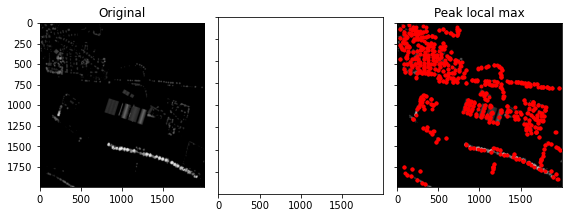

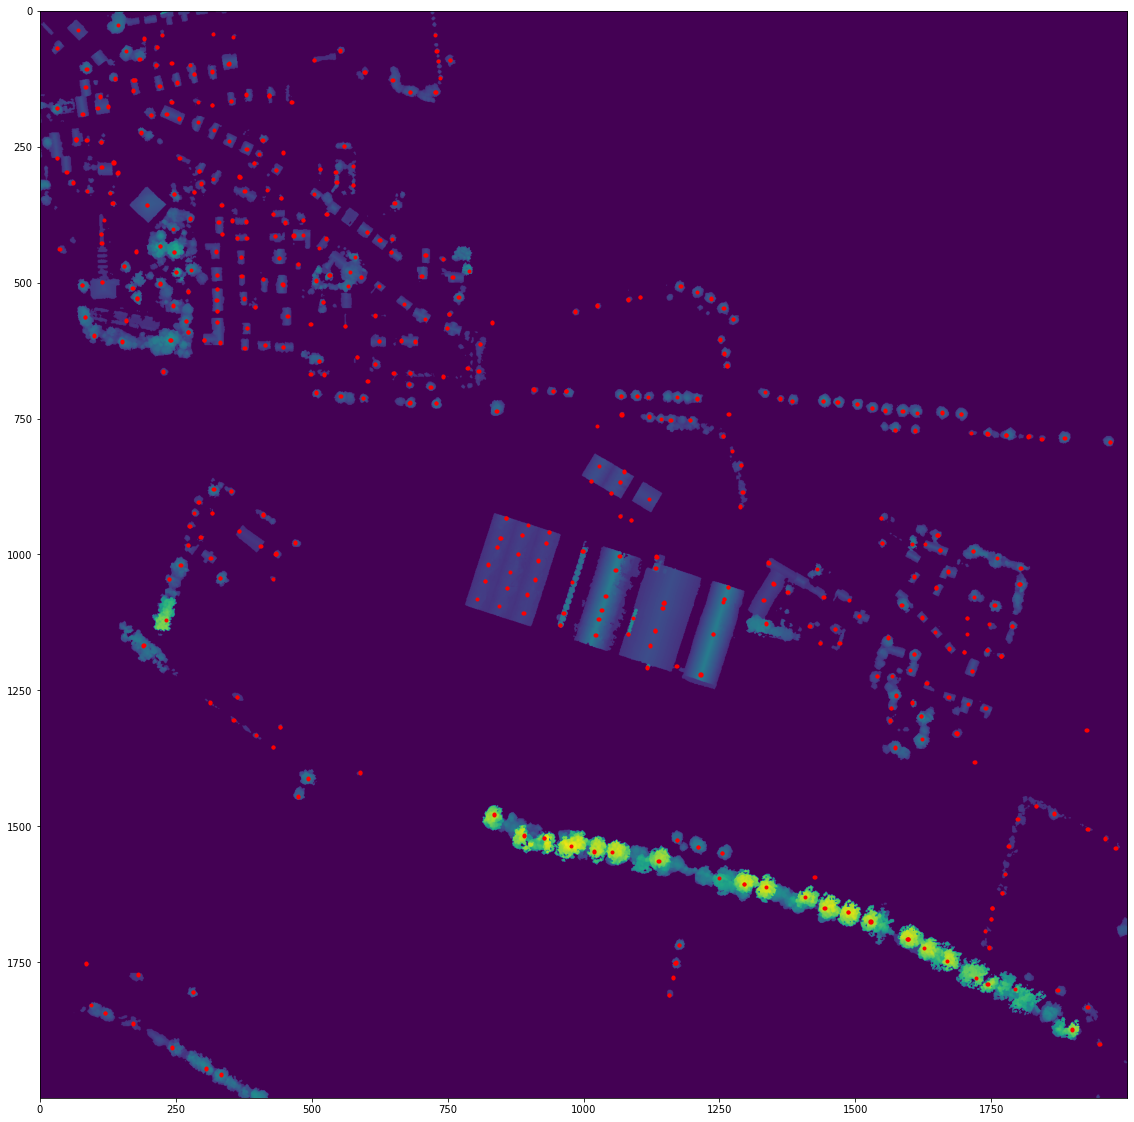

Anzahl Bäume: 889


In [2]:
#wenn hier die maxima im einfarbigen bereich auftauchen, ist der threshold oben zu niedrig
#hier kann über den min-distance-wert skaliert werden:
filter_size = 1
min_distance = 15

#image_max = ndi.maximum_filter(im, size=filter_size)   #, mode='constant'
# Comparison between image_max and im to find the coordinates of local maxima
coordinates = peak_local_max(im, min_distance=min_distance)




# display results:
fig, axes = plt.subplots(1, 3, figsize=(8, 3), sharex=True, sharey=True)
ax = axes.ravel()
ax[0].imshow(im, cmap=plt.cm.gray)
ax[0].set_title('Original')

#ax[1].imshow(image_max, cmap=plt.cm.gray)
#ax[1].set_title('Maximum filter')

ax[2].imshow(im, cmap=plt.cm.gray)
ax[2].plot(coordinates[:, 1], coordinates[:, 0], 'r.')
ax[2].set_title('Peak local max')

fig.tight_layout()

plt.show()

plt.imshow(im)
plt.plot(coordinates[:, 1], coordinates[:, 0], 'r.')
plt.show()
print("Anzahl Bäume:", len(coordinates))

In [3]:
import laspy

#las_file = "lidar-files/4merged/Wesel/3dm_32_324_5729_1_nw.laz"
las = laspy.read(las_file)



In [4]:
las_points_x = numpy.array(las.points['x']) 
las_points_y = numpy.array(las.points['y'])
x_max, x_min, y_max, y_min = las_points_x.max(),  las_points_x.min(), las_points_y.max(),  las_points_y.min()
x_range = x_max - x_min
y_range = y_max - y_min
print(x_max, x_min,x_range, y_max, y_min, y_range)

330999.99 330000.0 999.9899999999907 5723999.99 5723000.0 999.9900000002235


In [5]:
import pandas

#koordinaten vom geotiff  bestimmen - > utm koodinate jedes pixels ableiten  - > die coordiates-liste umrechnen 
#- > nächste punkte bestimmen
#load metadata csv
meta_data = pandas.read_csv("metadata/ndom_nw.csv", sep=";")
kachelname = bdom_file.split("/")[-1].split(".")[0]
row = meta_data.loc[meta_data['Kachelname'] == kachelname]

#cpnvert coordinates to ut coords_
x_pixels, y_pixels = im.shape[1],im.shape[0]
step = row['Aufloesung_cm'].values[0]/100  #0.5m per pixel!
utm_coordinates = numpy.zeros((len(coordinates), 2))
for i in range(len(utm_coordinates)):
    utm_coordinates[i][0] = coordinates[i][1] * step + x_min
    utm_coordinates[i][1] = y_max - coordinates[i][0] * step


In [6]:
#check utm_coordinates:
import folium
import coord_f
tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',



lat,long = coord_f.utm_to_lat_long(x_max, y_max)
lat_min,long_min = coord_f.utm_to_lat_long(x_min, y_min)

f_map = folium.Map(location=[lat, long], zoom_start=14)
#add las area:
folium.Marker(location=[lat, long],icon=folium.Icon(color="red")).add_to( f_map )
folium.Marker(location=[lat_min, long_min],icon=folium.Icon(color="red")).add_to( f_map )
folium.Marker(location=[lat, long_min],icon=folium.Icon(color="red")).add_to( f_map )
folium.Marker(location=[lat_min, long],icon=folium.Icon(color="red")).add_to( f_map )

latlong_coordinates = list(map(coord_f.utm_to_lat_long, list(zip(*utm_coordinates))[0],  list(zip(*utm_coordinates))[1]))
#add trees:
for lat, long in latlong_coordinates:
    folium.Marker(location=[lat, long],icon=folium.Icon(color="green")).add_to( f_map )

f_map

In [15]:
from scipy.spatial import distance
from tqdm import tqdm
#find list of nearest points in las:    
centroids_in_las = numpy.zeros((len(utm_coordinates), 3))
las_points = numpy.array((las.points['x'], las.points['y'])).transpose()  #hier noch nach classification filtern!
print(las_points)
for i in tqdm(range(len(utm_coordinates) -1, -1, -1 )):
        closest_index = int(distance.cdist([ utm_coordinates[i]], las_points).argmin())
        c = las.points['classification'][closest_index]
        if c in [0, 1, 4,5]:
            centroids_in_las[i] = las.points['x'][closest_index], las.points['y'][closest_index],las.points['z'][closest_index]
        else:
            centroids_in_las = numpy.delete(centroids_in_las, i,  axis=0)
print(centroids_in_las)

print(len(centroids_in_las))

[[ 330016.28 5723000.2 ]
 [ 330016.66 5723000.11]
 [ 330015.19 5723000.13]
 ...
 [ 330999.87 5723999.24]
 [ 330999.83 5723999.55]
 [ 330999.79 5723999.83]]


100%|██████████| 889/889 [01:11<00:00, 12.37it/s]

[[3.30166640e+05 5.72302143e+06 1.69500000e+01]
 [3.30166610e+05 5.72302204e+06 1.97100000e+01]
 [3.30153070e+05 5.72302756e+06 2.08500000e+01]
 ...
 [3.30177380e+05 5.72397594e+06 2.44900000e+01]
 [3.30363140e+05 5.72397805e+06 2.38700000e+01]
 [3.30159390e+05 5.72397893e+06 2.48900000e+01]]
436


In [16]:
lat,long = coord_f.utm_to_lat_long(x_max, y_max)
lat_min,long_min = coord_f.utm_to_lat_long(x_min, y_min)

f_map = folium.Map(location=[lat, long], zoom_start=14)
#add las area:
folium.Marker(location=[lat, long],icon=folium.Icon(color="red")).add_to( f_map )
folium.Marker(location=[lat_min, long_min],icon=folium.Icon(color="red")).add_to( f_map )
folium.Marker(location=[lat, long_min],icon=folium.Icon(color="red")).add_to( f_map )
folium.Marker(location=[lat_min, long],icon=folium.Icon(color="red")).add_to( f_map )

latlong_coordinates = list(map(coord_f.utm_to_lat_long, list(zip(*centroids_in_las))[0],  list(zip(*centroids_in_las))[1]))
#add trees:
for lat, long in latlong_coordinates:
    folium.Marker(location=[lat, long],icon=folium.Icon(color="green")).add_to( f_map )

f_map

0 Nie klassifiziert
1 Nicht zugewiesen
2 Oberfläche
3 Niedrige Vegetation
4 Mittelhohe Vegetation
5 Hohe Vegetation
6 Gebäude
7 Tiefpunkt
8 Reserviert
9 Wasser
10 Schienen
11 Straßenbelag
12 Reserviert
13 Schutzdraht (Schild)
14 Drahtleiter (Phase)
15 Strommast
16 Leitungsverbinder (Isolator)
17 Brückenfahrbahn
18 Hohes Rauschen

In [17]:
import clustering
used_classifications = [0,1]
points_to_cluster = numpy.array([[las.points['x'][i], las.points['y'][i], las.points['z'][i]] for i in tqdm(range(len(las.points['x']))) if (las.points['classification'][i] in used_classifications)]) 
#geht das mit fiter vielleicht schneller? 1:30 ist viel zu langsam..

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


100%|██████████| 9805369/9805369 [02:29<00:00, 65724.21it/s]


In [ ]:
#print(centroids_in_las)
print(points_to_cluster)

clustering.k_means_no_dbscan(centroids_in_las, points_to_cluster)

[[3.30014220e+05 5.72300006e+06 1.54400000e+01]
 [3.30012100e+05 5.72300005e+06 1.55600000e+01]
 [3.30010930e+05 5.72300003e+06 1.56400000e+01]
 ...
 [3.30888630e+05 5.72398401e+06 2.01200000e+01]
 [3.30888250e+05 5.72399543e+06 2.01300000e+01]
 [3.30915290e+05 5.72398004e+06 2.02000000e+01]]
starting k-means:
finish!


100%|██████████| 436/436 [00:00<00:00, 446682.11it/s]


label_colors (436, 3)


 98%|█████████▊| 1459850/1489991 [00:02<00:00, 608987.42it/s]